In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tqdm import tqdm
import json
import fasttext

In [2]:
with open(r"data/NER_Train.json", 'r') as f:
    train_data = json.load(f)

with open(r'data/NER_Val.json', 'r') as f:
    val_data = json.load(f)
    
with open(r'data/NER_Test.json', 'r') as f:
    test_data = json.load(f)

In [3]:
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

# Path to your GloVe pre-trained embeddings file
glove_file_path = 'glove.6B.300d.txt'

# Load GloVe embeddings
model = load_glove_model(glove_file_path)

Loading Glove Model
400000 words loaded!


In [4]:
word_embedding = model.get('hello')
print(word_embedding)

[-3.3712e-01 -2.1691e-01 -6.6365e-03 -4.1625e-01 -1.2555e+00 -2.8466e-02
 -7.2195e-01 -5.2887e-01  7.2085e-03  3.1997e-01  2.9425e-02 -1.3236e-02
  4.3511e-01  2.5716e-01  3.8995e-01 -1.1968e-01  1.5035e-01  4.4762e-01
  2.8407e-01  4.9339e-01  6.2826e-01  2.2888e-01 -4.0385e-01  2.7364e-02
  7.3679e-03  1.3995e-01  2.3346e-01  6.8122e-02  4.8422e-01 -1.9578e-02
 -5.4751e-01 -5.4983e-01 -3.4091e-02  8.0017e-03 -4.3065e-01 -1.8969e-02
 -8.5670e-02 -8.1123e-01 -2.1080e-01  3.7784e-01 -3.5046e-01  1.3684e-01
 -5.5661e-01  1.6835e-01 -2.2952e-01 -1.6184e-01  6.7345e-01 -4.6597e-01
 -3.1834e-02 -2.6037e-01 -1.7797e-01  1.9436e-02  1.0727e-01  6.6534e-01
 -3.4836e-01  4.7833e-02  1.6440e-01  1.4088e-01  1.9204e-01 -3.5009e-01
  2.6236e-01  1.7626e-01 -3.1367e-01  1.1709e-01  2.0378e-01  6.1775e-01
  4.9075e-01 -7.5210e-02 -1.1815e-01  1.8685e-01  4.0679e-01  2.8319e-01
 -1.6290e-01  3.8388e-02  4.3794e-01  8.8224e-02  5.9046e-01 -5.3515e-02
  3.8819e-02  1.8202e-01 -2.7599e-01  3.9474e-01 -2

In [5]:

def convert_data_to_tensors(data, model):
    texts = [data[key]['text'] for key in data]

    # Convert texts to word embeddings
    embeddings = []
    for text in texts:
        embedding = []
        for word in text.split():
            # Check if word exists in the model's vocabulary
            if word in model:
                embedding.append(model[word])
            else:
                # If word not found, use zero vector
                embedding.append([0] * model["hello"].size)
        embeddings.append(embedding)

    # Pad sequences to have the same length
    max_len = 70  # maximum length of word in a text
    padded_embeddings = []
    for embedding in embeddings:
        padded_embedding = embedding + [[0] * model["hello"].size] * (max_len - len(embedding))
        padded_embeddings.append(padded_embedding)

    # Filter out None values
    padded_embeddings = [embedding for embedding in padded_embeddings if embedding is not None]

    # Convert to tensor
    input_ids = torch.tensor(padded_embeddings, dtype=torch.float32)

    return input_ids

In [6]:

x_train = convert_data_to_tensors(train_data, model)
x_val = convert_data_to_tensors(val_data, model)
x_test = convert_data_to_tensors(test_data, model)

/tmp/ipykernel_48855/601243325.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/torch/csrc/utils/tensor_new.cpp:275.)
  input_ids = torch.tensor(padded_embeddings, dtype=torch.float32)


In [7]:
x_train.size()

torch.Size([8019, 70, 300])

In [8]:
# unique_labels = set()
# for example in train_data.values():
#     unique_labels.update(example['labels'])
# for example in test_data.values():
#     unique_labels.update(example['labels'])
# for example in val_data.values():
#     unique_labels.update(example['labels'])
# unique_labels.remove('O')
# label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
# label_to_index['O'] = max(label_to_index.values()) +1
# print((label_to_index))

In [9]:
def convert_labels_to_fixed_length(labels, max_length):
    label_to_index = {'I_WITNESS': 0, 'B_JUDGE': 1, 'I_CASE_NUMBER': 2, 'B_CASE_NUMBER': 3, 'I_PROVISION': 4, 'B_STATUTE': 5, 'I_DATE': 6, 'I_STATUTE': 7, 'B_WITNESS': 8, 'B_DATE': 9, 'I_RESPONDENT': 10, 'B_PRECEDENT': 11, 'B_GPE': 12, 'I_ORG': 13, 'I_PETITIONER': 14, 'B_PROVISION': 15, 'B_ORG': 16, 'I_JUDGE': 17, 'I_OTHER_PERSON': 18, 'B_COURT': 19, 'B_PETITIONER': 20, 'B_RESPONDENT': 21, 'I_PRECEDENT': 22, 'I_COURT': 23, 'I_GPE': 24, 'B_OTHER_PERSON': 25, 'O': 26, '<pad>':27}
    new_list=[]
    num_labels = len(label_to_index)
    fixed_length_labels = np.zeros((len(labels), max_length))
    for i, example_labels in enumerate(labels):
        for j, label in enumerate(example_labels[:max_length]):
            fixed_length_labels[i, j] = label_to_index[label]
        for k in range(len(example_labels[:max_length]),max_length):
            fixed_length_labels[i, k] = 27
        new_list.append(len(example_labels[:max_length]))
    return fixed_length_labels,new_list

max_length = 70
train_labels = [train_data[key]['labels'] for key in train_data]
train_lab,length_train = convert_labels_to_fixed_length(train_labels, max_length)
y_train = torch.tensor(train_lab)


val_labels = [val_data[key]['labels'] for key in val_data]
val_lab,length_val = convert_labels_to_fixed_length(val_labels, max_length)
y_val = torch.tensor(val_lab)

test_labels = [test_data[key]['labels'] for key in test_data]
test_lab,length_test = convert_labels_to_fixed_length(test_labels, max_length)
y_test = torch.tensor(test_lab)

In [10]:
y_train.size()

torch.Size([8019, 70])

In [11]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


/home/bsumit43/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [12]:


# Assuming you have your data loaded into variables `X_train`, `y_train`, `X_val`, `y_val`
# X_train: (906, 83, 300), y_train: (906, 83, 3)
# X_val: (val_size, 83, 300), y_val: (val_size, 83, 3)

# Convert data to PyTorch tensors
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
length_train_tensor = torch.tensor(length_train)
length_val_tensor = torch.tensor(length_val)

# Define the RNN model
class LSTMTagger(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMTagger, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0,c0))
        out = self.fc(out)
        return out

# Define hyperparameters
input_size = 300  # Assuming word2vec embeddings size
hidden_size = 128
output_size = 28
learning_rate = 0.001
num_epochs = 130
batch_size = 128

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor,length_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
model = LSTMTagger(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    total_f1=0
    for batch_X, batch_y,l in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        outputs_r = [row[:index] for row, index in zip(outputs, l)]
        outputs_r_flat = torch.cat(outputs_r)
        y_pred_train = torch.argmax(outputs, dim=2)
        y_pred_padd_r = [row[:index] for row, index in zip(y_pred_train, l)] 
        y_train_flat = torch.cat(y_pred_padd_r)
        batch_y_r =  [row[:index] for row, index in zip(batch_y, l)]
        y_pred_flat = torch.cat(batch_y_r)
        loss = criterion(outputs_r_flat,y_pred_flat )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_f1 = f1_score(y_train_flat, y_pred_flat, average='macro')
        total_f1 += train_f1
    train_f1_scores.append(total_f1/ len(train_loader))
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        # Calculate F1 score
        y_pred = torch.argmax(val_outputs, dim=2)
        y_pred_val_padd_r = [row[:index] for row, index in zip(y_pred, length_val_tensor)] 
        y_pred_val_flat = torch.cat(y_pred_val_padd_r)
        y_val_tensor_r =  [row[:index] for row, index in zip(y_val_tensor, length_val_tensor)]
        y_val_tensor_r_f = torch.cat(y_val_tensor_r)
        
        val_outputs_r = [row[:index] for row, index in zip(val_outputs, length_val_tensor)]
        val_outputs_r_f = torch.cat(val_outputs_r)
        
        val_loss = criterion(val_outputs_r_f,y_val_tensor_r_f)
        val_losses.append(val_loss.item())

        
        val_f1 = f1_score(y_val_tensor_r_f, y_pred_val_flat, average='macro')
        val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Val F1: {val_f1}, Train F1: {train_f1_scores[-1]}")
    

/tmp/ipykernel_48855/2890137248.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/tmp/ipykernel_48855/2890137248.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
/tmp/ipykernel_48855/2890137248.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
/tmp/ipykernel_48855/2890137248.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

Epoch 1/130, Train Loss: 1.3501418308606223, Val Loss: 0.9399144649505615, Val F1: 0.03444516876634059, Train F1: 0.033684071991084356


  2%|▋                                          | 2/130 [00:10<10:46,  5.05s/it]

Epoch 2/130, Train Loss: 0.881080306711651, Val Loss: 0.8165168762207031, Val F1: 0.04622342942994884, Train F1: 0.039170379094948464


  2%|▉                                          | 3/130 [00:15<10:35,  5.00s/it]

Epoch 3/130, Train Loss: 0.7789022052098834, Val Loss: 0.7321082949638367, Val F1: 0.05647898333581531, Train F1: 0.05396667870456986


  3%|█▎                                         | 4/130 [00:20<10:28,  4.99s/it]

Epoch 4/130, Train Loss: 0.7102194589281839, Val Loss: 0.6774514317512512, Val F1: 0.09306621957485481, Train F1: 0.0742291745131602


  4%|█▋                                         | 5/130 [00:24<10:21,  4.97s/it]

Epoch 5/130, Train Loss: 0.6611149348909893, Val Loss: 0.635361909866333, Val F1: 0.11751921913293267, Train F1: 0.10777513214451909


  5%|█▉                                         | 6/130 [00:29<10:15,  4.96s/it]

Epoch 6/130, Train Loss: 0.6245462024022662, Val Loss: 0.606530487537384, Val F1: 0.12930814748745958, Train F1: 0.1257094482734359


  5%|██▎                                        | 7/130 [00:34<10:10,  4.96s/it]

Epoch 7/130, Train Loss: 0.5960115638990251, Val Loss: 0.5820134878158569, Val F1: 0.14452072933642596, Train F1: 0.14596683679879816


  6%|██▋                                        | 8/130 [00:39<10:07,  4.98s/it]

Epoch 8/130, Train Loss: 0.5717179865118057, Val Loss: 0.5594584345817566, Val F1: 0.16605389749715369, Train F1: 0.16086745285815612


  7%|██▉                                        | 9/130 [00:44<10:00,  4.96s/it]

Epoch 9/130, Train Loss: 0.5542732831977663, Val Loss: 0.5461528301239014, Val F1: 0.1660929336692121, Train F1: 0.16948766370920476


  8%|███▏                                      | 10/130 [00:49<09:54,  4.95s/it]

Epoch 10/130, Train Loss: 0.5381200758237688, Val Loss: 0.5323142409324646, Val F1: 0.1817476694913647, Train F1: 0.1773837442412996


  8%|███▌                                      | 11/130 [00:54<09:48,  4.95s/it]

Epoch 11/130, Train Loss: 0.5240153670310974, Val Loss: 0.5194560289382935, Val F1: 0.1797850569638845, Train F1: 0.1850397613755996


  9%|███▉                                      | 12/130 [00:59<09:46,  4.97s/it]

Epoch 12/130, Train Loss: 0.5113649713614631, Val Loss: 0.5118451118469238, Val F1: 0.1927375584742718, Train F1: 0.195228146059515


 10%|████▏                                     | 13/130 [01:04<09:40,  4.96s/it]

Epoch 13/130, Train Loss: 0.5018148895293947, Val Loss: 0.5059419274330139, Val F1: 0.18490989734428906, Train F1: 0.20116669249559682


 11%|████▌                                     | 14/130 [01:09<09:34,  4.95s/it]

Epoch 14/130, Train Loss: 0.4931114098382375, Val Loss: 0.4966333508491516, Val F1: 0.20574805934971727, Train F1: 0.20657779522644668


 12%|████▊                                     | 15/130 [01:14<09:28,  4.95s/it]

Epoch 15/130, Train Loss: 0.48523867556027006, Val Loss: 0.49103665351867676, Val F1: 0.2144300627074816, Train F1: 0.21366769673122885


 12%|█████▏                                    | 16/130 [01:19<09:22,  4.93s/it]

Epoch 16/130, Train Loss: 0.47830340218922446, Val Loss: 0.4903469681739807, Val F1: 0.21704308002335596, Train F1: 0.21793462045853712


 13%|█████▍                                    | 17/130 [01:24<09:19,  4.95s/it]

Epoch 17/130, Train Loss: 0.4713687598705292, Val Loss: 0.4854198098182678, Val F1: 0.20759880835317487, Train F1: 0.22065736358830348


 14%|█████▊                                    | 18/130 [01:29<09:12,  4.93s/it]

Epoch 18/130, Train Loss: 0.46706284464351716, Val Loss: 0.4831675589084625, Val F1: 0.1977490439287639, Train F1: 0.22531312196680153


 15%|██████▏                                   | 19/130 [01:34<09:07,  4.94s/it]

Epoch 19/130, Train Loss: 0.46137121698213, Val Loss: 0.4803024232387543, Val F1: 0.21369498545546353, Train F1: 0.22926422313753742


 15%|██████▍                                   | 20/130 [01:39<09:01,  4.93s/it]

Epoch 20/130, Train Loss: 0.45707729884556364, Val Loss: 0.4781455993652344, Val F1: 0.21377887516743732, Train F1: 0.2296247391396841


 16%|██████▊                                   | 21/130 [01:44<08:57,  4.93s/it]

Epoch 21/130, Train Loss: 0.450295998463555, Val Loss: 0.47773316502571106, Val F1: 0.21587360081100201, Train F1: 0.23916399335719296


 17%|███████                                   | 22/130 [01:49<08:52,  4.93s/it]

Epoch 22/130, Train Loss: 0.4466259910000695, Val Loss: 0.47906795144081116, Val F1: 0.2251334680629149, Train F1: 0.23924471750665935


 18%|███████▍                                  | 23/130 [01:54<08:50,  4.95s/it]

Epoch 23/130, Train Loss: 0.44318761333586676, Val Loss: 0.4777323007583618, Val F1: 0.22784905096363872, Train F1: 0.2436646833673649


 18%|███████▊                                  | 24/130 [01:58<08:43,  4.94s/it]

Epoch 24/130, Train Loss: 0.43924612138006425, Val Loss: 0.47489356994628906, Val F1: 0.2336540902205457, Train F1: 0.24269874354158552


 19%|████████                                  | 25/130 [02:03<08:39,  4.95s/it]

Epoch 25/130, Train Loss: 0.4338016751266661, Val Loss: 0.47678491473197937, Val F1: 0.23341668694025303, Train F1: 0.2516909581077783


 20%|████████▍                                 | 26/130 [02:08<08:33,  4.94s/it]

Epoch 26/130, Train Loss: 0.43182731478933306, Val Loss: 0.4729015827178955, Val F1: 0.23859987117536544, Train F1: 0.2538154190737792


 21%|████████▋                                 | 27/130 [02:13<08:28,  4.93s/it]

Epoch 27/130, Train Loss: 0.4270656903584798, Val Loss: 0.4746062755584717, Val F1: 0.2397383915264912, Train F1: 0.2611585965034327


 22%|█████████                                 | 28/130 [02:18<08:22,  4.92s/it]

Epoch 28/130, Train Loss: 0.4207615625290644, Val Loss: 0.47527027130126953, Val F1: 0.2476391363038916, Train F1: 0.26485889675758806


 22%|█████████▎                                | 29/130 [02:23<08:16,  4.91s/it]

Epoch 29/130, Train Loss: 0.4186096541465275, Val Loss: 0.47633442282676697, Val F1: 0.23283284646051275, Train F1: 0.26695185105779073


 23%|█████████▋                                | 30/130 [02:28<08:16,  4.96s/it]

Epoch 30/130, Train Loss: 0.41428921714661615, Val Loss: 0.473220556974411, Val F1: 0.25586442900528095, Train F1: 0.2732122434384039


 24%|██████████                                | 31/130 [02:33<08:14,  4.99s/it]

Epoch 31/130, Train Loss: 0.40833745967774165, Val Loss: 0.47971007227897644, Val F1: 0.25515097886185706, Train F1: 0.2770917948296353


 25%|██████████▎                               | 32/130 [02:38<08:06,  4.96s/it]

Epoch 32/130, Train Loss: 0.4053524235884349, Val Loss: 0.4816414415836334, Val F1: 0.24428364801098923, Train F1: 0.2799359715657079


 25%|██████████▋                               | 33/130 [02:43<07:59,  4.94s/it]

Epoch 33/130, Train Loss: 0.40108463925028603, Val Loss: 0.4826878011226654, Val F1: 0.24081442930722619, Train F1: 0.2869110565739016


 26%|██████████▉                               | 34/130 [02:48<07:55,  4.95s/it]

Epoch 34/130, Train Loss: 0.3958081953109257, Val Loss: 0.4792073667049408, Val F1: 0.2552363802121763, Train F1: 0.28758227943919346


 27%|███████████▎                              | 35/130 [02:53<07:48,  4.94s/it]

Epoch 35/130, Train Loss: 0.3919577149171678, Val Loss: 0.4827318787574768, Val F1: 0.2528389310490826, Train F1: 0.298095629923517


 28%|███████████▋                              | 36/130 [02:58<07:43,  4.93s/it]

Epoch 36/130, Train Loss: 0.39229718607569497, Val Loss: 0.4878380596637726, Val F1: 0.25354506076173655, Train F1: 0.2970797818420439


 28%|███████████▉                              | 37/130 [03:03<07:37,  4.92s/it]

Epoch 37/130, Train Loss: 0.38640558861550833, Val Loss: 0.49149584770202637, Val F1: 0.246466486795687, Train F1: 0.3029724064838988


 29%|████████████▎                             | 38/130 [03:08<07:32,  4.92s/it]

Epoch 38/130, Train Loss: 0.3804337978363037, Val Loss: 0.4854680299758911, Val F1: 0.2664131688222561, Train F1: 0.31020376070918987


 30%|████████████▌                             | 39/130 [03:12<07:27,  4.91s/it]

Epoch 39/130, Train Loss: 0.37650263877142043, Val Loss: 0.49027127027511597, Val F1: 0.25769827464659845, Train F1: 0.3161444361288551


 31%|████████████▉                             | 40/130 [03:17<07:22,  4.91s/it]

Epoch 40/130, Train Loss: 0.37319775990077425, Val Loss: 0.502296507358551, Val F1: 0.25542873227492197, Train F1: 0.3228064545719486


 32%|█████████████▏                            | 41/130 [03:22<07:16,  4.90s/it]

Epoch 41/130, Train Loss: 0.3710719030054789, Val Loss: 0.4961870312690735, Val F1: 0.26002005315747717, Train F1: 0.3203938121950117


 32%|█████████████▌                            | 42/130 [03:27<07:15,  4.95s/it]

Epoch 42/130, Train Loss: 0.3648016154766083, Val Loss: 0.497156023979187, Val F1: 0.26691454001314713, Train F1: 0.3279279692602558


 33%|█████████████▉                            | 43/130 [03:32<07:14,  4.99s/it]

Epoch 43/130, Train Loss: 0.3613284126160637, Val Loss: 0.5018329620361328, Val F1: 0.2647440615845167, Train F1: 0.3323796592032308


 34%|██████████████▏                           | 44/130 [03:37<07:07,  4.97s/it]

Epoch 44/130, Train Loss: 0.3599852692513239, Val Loss: 0.5076847672462463, Val F1: 0.2688008690414674, Train F1: 0.3352425600436291


 35%|██████████████▌                           | 45/130 [03:42<07:04,  4.99s/it]

Epoch 45/130, Train Loss: 0.3540992769930098, Val Loss: 0.514172375202179, Val F1: 0.26817480267472776, Train F1: 0.34600121033536707


 35%|██████████████▊                           | 46/130 [03:47<06:57,  4.97s/it]

Epoch 46/130, Train Loss: 0.3500410999570574, Val Loss: 0.5154933333396912, Val F1: 0.2654860892834599, Train F1: 0.3488711169163389


 36%|███████████████▏                          | 47/130 [03:52<06:56,  5.01s/it]

Epoch 47/130, Train Loss: 0.34934869550523306, Val Loss: 0.5229584574699402, Val F1: 0.24229418338285683, Train F1: 0.35513345557326065


 37%|███████████████▌                          | 48/130 [03:57<06:49,  4.99s/it]

Epoch 48/130, Train Loss: 0.34561196206107975, Val Loss: 0.5237278938293457, Val F1: 0.26759204831418754, Train F1: 0.3593919584456022


 38%|███████████████▊                          | 49/130 [04:02<06:43,  4.98s/it]

Epoch 49/130, Train Loss: 0.33994581349312314, Val Loss: 0.5364864468574524, Val F1: 0.2650162886199949, Train F1: 0.3648088394688178


 38%|████████████████▏                         | 50/130 [04:07<06:38,  4.98s/it]

Epoch 50/130, Train Loss: 0.33858559954734074, Val Loss: 0.5286850929260254, Val F1: 0.2703287121295648, Train F1: 0.36871765129950335


 39%|████████████████▍                         | 51/130 [04:13<06:51,  5.21s/it]

Epoch 51/130, Train Loss: 0.335737477219294, Val Loss: 0.543371319770813, Val F1: 0.25601768418372717, Train F1: 0.37300980461946287


 40%|████████████████▊                         | 52/130 [04:18<06:41,  5.14s/it]

Epoch 52/130, Train Loss: 0.3306247426403893, Val Loss: 0.5308800339698792, Val F1: 0.27837696052205396, Train F1: 0.37901198626853116


 41%|█████████████████                         | 53/130 [04:23<06:30,  5.07s/it]

Epoch 53/130, Train Loss: 0.32379011313120526, Val Loss: 0.5414813160896301, Val F1: 0.26795739729069823, Train F1: 0.3889232455448488


 42%|█████████████████▍                        | 54/130 [04:28<06:21,  5.02s/it]

Epoch 54/130, Train Loss: 0.3239317261983478, Val Loss: 0.5609344840049744, Val F1: 0.2581634882488432, Train F1: 0.3910508536579288


 42%|█████████████████▊                        | 55/130 [04:33<06:15,  5.00s/it]

Epoch 55/130, Train Loss: 0.31769789069417925, Val Loss: 0.5677685141563416, Val F1: 0.25593304613013473, Train F1: 0.39826371428443846


 43%|██████████████████                        | 56/130 [04:38<06:10,  5.00s/it]

Epoch 56/130, Train Loss: 0.31838960969258867, Val Loss: 0.5590087175369263, Val F1: 0.26420542605100483, Train F1: 0.4018057766842077


 44%|██████████████████▍                       | 57/130 [04:43<06:03,  4.97s/it]

Epoch 57/130, Train Loss: 0.3121709965524219, Val Loss: 0.562179446220398, Val F1: 0.27631027285648374, Train F1: 0.4046893005591583


 45%|██████████████████▋                       | 58/130 [04:48<05:58,  4.97s/it]

Epoch 58/130, Train Loss: 0.30840026528116254, Val Loss: 0.5603498816490173, Val F1: 0.2778143806541391, Train F1: 0.4108785991216954


 45%|███████████████████                       | 59/130 [04:53<05:55,  5.01s/it]

Epoch 59/130, Train Loss: 0.3045895832871634, Val Loss: 0.5607187151908875, Val F1: 0.27471093230132687, Train F1: 0.4181332033844291


 46%|███████████████████▍                      | 60/130 [04:58<05:53,  5.05s/it]

Epoch 60/130, Train Loss: 0.3016251931114802, Val Loss: 0.5689727663993835, Val F1: 0.2687705198905252, Train F1: 0.4204260305111065


 47%|███████████████████▋                      | 61/130 [05:03<05:47,  5.03s/it]

Epoch 61/130, Train Loss: 0.29753537688936504, Val Loss: 0.5843074917793274, Val F1: 0.2605500995029923, Train F1: 0.428613218013373


 48%|████████████████████                      | 62/130 [05:08<05:42,  5.04s/it]

Epoch 62/130, Train Loss: 0.29530324987948886, Val Loss: 0.5758511424064636, Val F1: 0.27273258878938816, Train F1: 0.4363409351335808


 48%|████████████████████▎                     | 63/130 [05:13<05:45,  5.15s/it]

Epoch 63/130, Train Loss: 0.29702713494263, Val Loss: 0.5867685675621033, Val F1: 0.27834693686890755, Train F1: 0.4341119969989624


 49%|████████████████████▋                     | 64/130 [05:19<05:42,  5.20s/it]

Epoch 64/130, Train Loss: 0.2975379245148765, Val Loss: 0.5868718028068542, Val F1: 0.267226463561916, Train F1: 0.42699084631948325


 50%|█████████████████████                     | 65/130 [05:24<05:35,  5.16s/it]

Epoch 65/130, Train Loss: 0.288670634939557, Val Loss: 0.5856459140777588, Val F1: 0.28252490629865057, Train F1: 0.4433358965181447


 51%|█████████████████████▎                    | 66/130 [05:29<05:31,  5.18s/it]

Epoch 66/130, Train Loss: 0.2822463219127958, Val Loss: 0.6267046928405762, Val F1: 0.2662949022805716, Train F1: 0.4478572326037277


 52%|█████████████████████▋                    | 67/130 [05:34<05:25,  5.16s/it]

Epoch 67/130, Train Loss: 0.2781716663213003, Val Loss: 0.6091693043708801, Val F1: 0.2827024041581929, Train F1: 0.4572764219613209


 52%|█████████████████████▉                    | 68/130 [05:39<05:18,  5.14s/it]

Epoch 68/130, Train Loss: 0.2772998400623836, Val Loss: 0.6180294752120972, Val F1: 0.273223810987925, Train F1: 0.459270926799915


 53%|██████████████████████▎                   | 69/130 [05:44<05:11,  5.11s/it]

Epoch 69/130, Train Loss: 0.27278645738722784, Val Loss: 0.6272584795951843, Val F1: 0.27621310047432845, Train F1: 0.4688881452164585


 54%|██████████████████████▌                   | 70/130 [05:49<05:01,  5.03s/it]

Epoch 70/130, Train Loss: 0.2684701177335921, Val Loss: 0.6348918676376343, Val F1: 0.268948744658608, Train F1: 0.47692842194898555


 55%|██████████████████████▉                   | 71/130 [05:54<04:54,  4.99s/it]

Epoch 71/130, Train Loss: 0.26597134295910124, Val Loss: 0.6381758451461792, Val F1: 0.26433383741982525, Train F1: 0.4777252513144177


 55%|███████████████████████▎                  | 72/130 [05:59<04:48,  4.98s/it]

Epoch 72/130, Train Loss: 0.2650973162953816, Val Loss: 0.6401984095573425, Val F1: 0.28039606190969274, Train F1: 0.4805792926100682


 56%|███████████████████████▌                  | 73/130 [06:04<04:45,  5.00s/it]

Epoch 73/130, Train Loss: 0.2624914565729716, Val Loss: 0.655157208442688, Val F1: 0.2737834879481053, Train F1: 0.4877340040292597


 57%|███████████████████████▉                  | 74/130 [06:09<04:38,  4.97s/it]

Epoch 74/130, Train Loss: 0.2650196124163885, Val Loss: 0.680078387260437, Val F1: 0.2745217633999373, Train F1: 0.4857796007885928


 58%|████████████████████████▏                 | 75/130 [06:14<04:32,  4.96s/it]

Epoch 75/130, Train Loss: 0.2582240506770119, Val Loss: 0.670275092124939, Val F1: 0.2669639342710528, Train F1: 0.49230450632663


 58%|████████████████████████▌                 | 76/130 [06:19<04:26,  4.94s/it]

Epoch 76/130, Train Loss: 0.25191953423477353, Val Loss: 0.6811277866363525, Val F1: 0.26331810664414174, Train F1: 0.5046676114573371


 59%|████████████████████████▉                 | 77/130 [06:24<04:20,  4.92s/it]

Epoch 77/130, Train Loss: 0.2518108134704923, Val Loss: 0.6825290322303772, Val F1: 0.26844335759549476, Train F1: 0.5062505827911848


 60%|█████████████████████████▏                | 78/130 [06:29<04:16,  4.94s/it]

Epoch 78/130, Train Loss: 0.25088982260416426, Val Loss: 0.6834356784820557, Val F1: 0.2725365641506922, Train F1: 0.5084163946817694


 61%|█████████████████████████▌                | 79/130 [06:33<04:11,  4.93s/it]

Epoch 79/130, Train Loss: 0.24591703665634942, Val Loss: 0.7162294387817383, Val F1: 0.25700553490230854, Train F1: 0.5170669708090379


 62%|█████████████████████████▊                | 80/130 [06:38<04:06,  4.93s/it]

Epoch 80/130, Train Loss: 0.24351318629961166, Val Loss: 0.6956290006637573, Val F1: 0.2693887044497693, Train F1: 0.5187523961759939


 62%|██████████████████████████▏               | 81/130 [06:43<04:01,  4.93s/it]

Epoch 81/130, Train Loss: 0.24364974101384482, Val Loss: 0.7062489986419678, Val F1: 0.2728716884171472, Train F1: 0.5234859695608092


 63%|██████████████████████████▍               | 82/130 [06:48<03:56,  4.93s/it]

Epoch 82/130, Train Loss: 0.23961544604528517, Val Loss: 0.7035854458808899, Val F1: 0.2774990259582658, Train F1: 0.535179398578212


 64%|██████████████████████████▊               | 83/130 [06:53<03:51,  4.93s/it]

Epoch 83/130, Train Loss: 0.23667102602739182, Val Loss: 0.7277758121490479, Val F1: 0.26804700176281493, Train F1: 0.5360966567886594


 65%|███████████████████████████▏              | 84/130 [06:58<03:47,  4.95s/it]

Epoch 84/130, Train Loss: 0.23135197470112454, Val Loss: 0.7293261289596558, Val F1: 0.27277145144808607, Train F1: 0.5442446457885921


 65%|███████████████████████████▍              | 85/130 [07:03<03:42,  4.94s/it]

Epoch 85/130, Train Loss: 0.22943822684742154, Val Loss: 0.7424716949462891, Val F1: 0.26249049478864733, Train F1: 0.5537620954178024


 66%|███████████████████████████▊              | 86/130 [07:08<03:38,  4.96s/it]

Epoch 86/130, Train Loss: 0.2273706921509334, Val Loss: 0.7366515398025513, Val F1: 0.2694283637981209, Train F1: 0.558332927053696


 67%|████████████████████████████              | 87/130 [07:13<03:33,  4.96s/it]

Epoch 87/130, Train Loss: 0.2279721429896733, Val Loss: 0.7661720514297485, Val F1: 0.25235481901463286, Train F1: 0.5576282523077034


 68%|████████████████████████████▍             | 88/130 [07:18<03:28,  4.96s/it]

Epoch 88/130, Train Loss: 0.2309739135560535, Val Loss: 0.7377505302429199, Val F1: 0.2672712271670811, Train F1: 0.5526370066570668


 68%|████████████████████████████▊             | 89/130 [07:23<03:23,  4.96s/it]

Epoch 89/130, Train Loss: 0.22352668926829383, Val Loss: 0.7447392344474792, Val F1: 0.26553470335903245, Train F1: 0.5647112926278961


 69%|█████████████████████████████             | 90/130 [07:28<03:17,  4.94s/it]

Epoch 90/130, Train Loss: 0.2192429621068258, Val Loss: 0.7761745452880859, Val F1: 0.2587593765730982, Train F1: 0.5752275155598706


 70%|█████████████████████████████▍            | 91/130 [07:33<03:12,  4.93s/it]

Epoch 91/130, Train Loss: 0.21643356553145818, Val Loss: 0.7916447520256042, Val F1: 0.2638464584348598, Train F1: 0.5751907316606304


 71%|█████████████████████████████▋            | 92/130 [07:38<03:06,  4.92s/it]

Epoch 92/130, Train Loss: 0.21457410213493167, Val Loss: 0.7839222550392151, Val F1: 0.26786493964712754, Train F1: 0.5794240070751284


 72%|██████████████████████████████            | 93/130 [07:43<03:01,  4.91s/it]

Epoch 93/130, Train Loss: 0.21225811706648934, Val Loss: 0.7835912704467773, Val F1: 0.2653597846843934, Train F1: 0.5876021525293266


 72%|██████████████████████████████▎           | 94/130 [07:47<02:56,  4.91s/it]

Epoch 94/130, Train Loss: 0.20978510025001706, Val Loss: 0.7873585820198059, Val F1: 0.26410353398040126, Train F1: 0.5927061424806396


 73%|██████████████████████████████▋           | 95/130 [07:52<02:51,  4.90s/it]

Epoch 95/130, Train Loss: 0.21007061477691408, Val Loss: 0.8023850321769714, Val F1: 0.2728663064016704, Train F1: 0.5905952030621139


 74%|███████████████████████████████           | 96/130 [07:57<02:46,  4.90s/it]

Epoch 96/130, Train Loss: 0.20981479637206546, Val Loss: 0.8303073048591614, Val F1: 0.2670177439908317, Train F1: 0.5885990203739049


 75%|███████████████████████████████▎          | 97/130 [08:02<02:41,  4.90s/it]

Epoch 97/130, Train Loss: 0.20639790807451522, Val Loss: 0.8126775622367859, Val F1: 0.2638997019979562, Train F1: 0.6038477522503222


 75%|███████████████████████████████▋          | 98/130 [08:07<02:36,  4.89s/it]

Epoch 98/130, Train Loss: 0.20799128545655143, Val Loss: 0.8057678937911987, Val F1: 0.27583679600586325, Train F1: 0.5982170035892372


 76%|███████████████████████████████▉          | 99/130 [08:12<02:31,  4.89s/it]

Epoch 99/130, Train Loss: 0.2083280405827931, Val Loss: 0.8240090012550354, Val F1: 0.26962468616912794, Train F1: 0.5974601673402405


 77%|███████████████████████████████▌         | 100/130 [08:17<02:27,  4.93s/it]

Epoch 100/130, Train Loss: 0.2040855082727614, Val Loss: 0.7973887324333191, Val F1: 0.2769530307258175, Train F1: 0.6066183570180782


 78%|███████████████████████████████▊         | 101/130 [08:20<02:03,  4.24s/it]

Epoch 101/130, Train Loss: 0.21018672320577833, Val Loss: 0.8134752511978149, Val F1: 0.2716796283241872, Train F1: 0.5988018440532483


 78%|████████████████████████████████▏        | 102/130 [08:22<01:44,  3.73s/it]

Epoch 102/130, Train Loss: 0.19849928811429038, Val Loss: 0.8566769957542419, Val F1: 0.25673380654187505, Train F1: 0.6155250126085766


 79%|████████████████████████████████▍        | 103/130 [08:25<01:30,  3.37s/it]

Epoch 103/130, Train Loss: 0.19453752348347317, Val Loss: 0.8409857153892517, Val F1: 0.2639573758109799, Train F1: 0.6290739002668583


 80%|████████████████████████████████▊        | 104/130 [08:27<01:21,  3.14s/it]

Epoch 104/130, Train Loss: 0.19481494407805186, Val Loss: 0.8780378103256226, Val F1: 0.25862849153451645, Train F1: 0.6254681153734426


 81%|█████████████████████████████████        | 105/130 [08:30<01:14,  2.97s/it]

Epoch 105/130, Train Loss: 0.1941826863894387, Val Loss: 0.8673647046089172, Val F1: 0.26792693266500717, Train F1: 0.624854939774209


 82%|█████████████████████████████████▍       | 106/130 [08:32<01:08,  2.85s/it]

Epoch 106/130, Train Loss: 0.18718623239842672, Val Loss: 0.8757215738296509, Val F1: 0.26140173997086213, Train F1: 0.6426415007305868


 82%|█████████████████████████████████▋       | 107/130 [08:36<01:13,  3.21s/it]

Epoch 107/130, Train Loss: 0.18462028224316854, Val Loss: 0.9052807688713074, Val F1: 0.2598709207998326, Train F1: 0.6463746420713643


 83%|██████████████████████████████████       | 108/130 [08:39<01:07,  3.08s/it]

Epoch 108/130, Train Loss: 0.18279437318680777, Val Loss: 0.9032226204872131, Val F1: 0.26155166383202827, Train F1: 0.6519369550125401


 84%|██████████████████████████████████▍      | 109/130 [08:42<01:02,  2.98s/it]

Epoch 109/130, Train Loss: 0.17959910583874536, Val Loss: 0.9080392718315125, Val F1: 0.25966158339536666, Train F1: 0.6611414823376033


 85%|██████████████████████████████████▋      | 110/130 [08:45<00:57,  2.90s/it]

Epoch 110/130, Train Loss: 0.1799337679431552, Val Loss: 0.9260476231575012, Val F1: 0.25516676223446016, Train F1: 0.6573908229914173


 85%|███████████████████████████████████      | 111/130 [08:47<00:54,  2.86s/it]

Epoch 111/130, Train Loss: 0.1823874887019869, Val Loss: 0.8936969041824341, Val F1: 0.2677692959684748, Train F1: 0.6545414298460923


 86%|███████████████████████████████████▎     | 112/130 [08:50<00:50,  2.81s/it]

Epoch 112/130, Train Loss: 0.18022608449534763, Val Loss: 0.9371914863586426, Val F1: 0.2589054201504561, Train F1: 0.6581375821040026


 87%|███████████████████████████████████▋     | 113/130 [08:53<00:47,  2.80s/it]

Epoch 113/130, Train Loss: 0.1773438091788973, Val Loss: 0.9725194573402405, Val F1: 0.24979016130380252, Train F1: 0.6635597760646103


 88%|███████████████████████████████████▉     | 114/130 [08:56<00:44,  2.78s/it]

Epoch 114/130, Train Loss: 0.1764513791080505, Val Loss: 0.9469204545021057, Val F1: 0.2660774364244243, Train F1: 0.6731448992721079


 88%|████████████████████████████████████▎    | 115/130 [08:58<00:41,  2.77s/it]

Epoch 115/130, Train Loss: 0.18261022274456326, Val Loss: 0.913936197757721, Val F1: 0.26440921791630395, Train F1: 0.6583912097701935


 89%|████████████████████████████████████▌    | 116/130 [09:01<00:38,  2.77s/it]

Epoch 116/130, Train Loss: 0.17749674973033724, Val Loss: 0.9494332075119019, Val F1: 0.25564617777882087, Train F1: 0.6622866896882954


 90%|████████████████████████████████████▉    | 117/130 [09:04<00:35,  2.76s/it]

Epoch 117/130, Train Loss: 0.17161129651561616, Val Loss: 0.9605900049209595, Val F1: 0.2596306938574107, Train F1: 0.6735587501931976


 91%|█████████████████████████████████████▏   | 118/130 [09:07<00:33,  2.76s/it]

Epoch 118/130, Train Loss: 0.1700609986271177, Val Loss: 0.9612440466880798, Val F1: 0.25287006313837257, Train F1: 0.6856262422977963


 92%|█████████████████████████████████████▌   | 119/130 [09:09<00:30,  2.75s/it]

Epoch 119/130, Train Loss: 0.16620924382928817, Val Loss: 0.9725865721702576, Val F1: 0.2572275444072333, Train F1: 0.6942867237946431


 92%|█████████████████████████████████████▊   | 120/130 [09:12<00:27,  2.75s/it]

Epoch 120/130, Train Loss: 0.16494022262474847, Val Loss: 0.9648017883300781, Val F1: 0.25609667306309564, Train F1: 0.6975828567695689


 93%|██████████████████████████████████████▏  | 121/130 [09:15<00:24,  2.75s/it]

Epoch 121/130, Train Loss: 0.16273518237802717, Val Loss: 0.9998147487640381, Val F1: 0.2531219522071439, Train F1: 0.6963946482365386


 94%|██████████████████████████████████████▍  | 122/130 [09:18<00:22,  2.77s/it]

Epoch 122/130, Train Loss: 0.16320971955382635, Val Loss: 1.0331344604492188, Val F1: 0.23945858033179374, Train F1: 0.7013724956702146


 95%|██████████████████████████████████████▊  | 123/130 [09:20<00:19,  2.76s/it]

Epoch 123/130, Train Loss: 0.16450131223315284, Val Loss: 1.030808687210083, Val F1: 0.24726145553193357, Train F1: 0.6960054050983748


 95%|███████████████████████████████████████  | 124/130 [09:23<00:16,  2.77s/it]

Epoch 124/130, Train Loss: 0.16353115675941346, Val Loss: 0.9791155457496643, Val F1: 0.2640649961575599, Train F1: 0.7005898703029056


 96%|███████████████████████████████████████▍ | 125/130 [09:26<00:13,  2.79s/it]

Epoch 125/130, Train Loss: 0.1606239870427147, Val Loss: 1.0121241807937622, Val F1: 0.2576360846489022, Train F1: 0.7040160518238676


 97%|███████████████████████████████████████▋ | 126/130 [09:29<00:11,  2.80s/it]

Epoch 126/130, Train Loss: 0.1583635833055254, Val Loss: 1.0326588153839111, Val F1: 0.2519167674502109, Train F1: 0.7097619038255869


 98%|████████████████████████████████████████ | 127/130 [09:32<00:08,  2.79s/it]

Epoch 127/130, Train Loss: 0.16494417592646585, Val Loss: 1.0519540309906006, Val F1: 0.25523319646233567, Train F1: 0.6970143430709739


 98%|████████████████████████████████████████▎| 128/130 [09:34<00:05,  2.79s/it]

Epoch 128/130, Train Loss: 0.16497573422061074, Val Loss: 1.018977165222168, Val F1: 0.2512676980594218, Train F1: 0.6981649468580932


 99%|████████████████████████████████████████▋| 129/130 [09:37<00:02,  2.78s/it]

Epoch 129/130, Train Loss: 0.15740851573054754, Val Loss: 1.0375467538833618, Val F1: 0.25055463991217897, Train F1: 0.7072549045160084


100%|█████████████████████████████████████████| 130/130 [09:40<00:00,  4.47s/it]

Epoch 130/130, Train Loss: 0.15436041934622657, Val Loss: 1.0251580476760864, Val F1: 0.2591661790062745, Train F1: 0.7126081591855608


In [13]:
# Save the model
torch.save(model.state_dict(), 't1_model2_glove.pth')

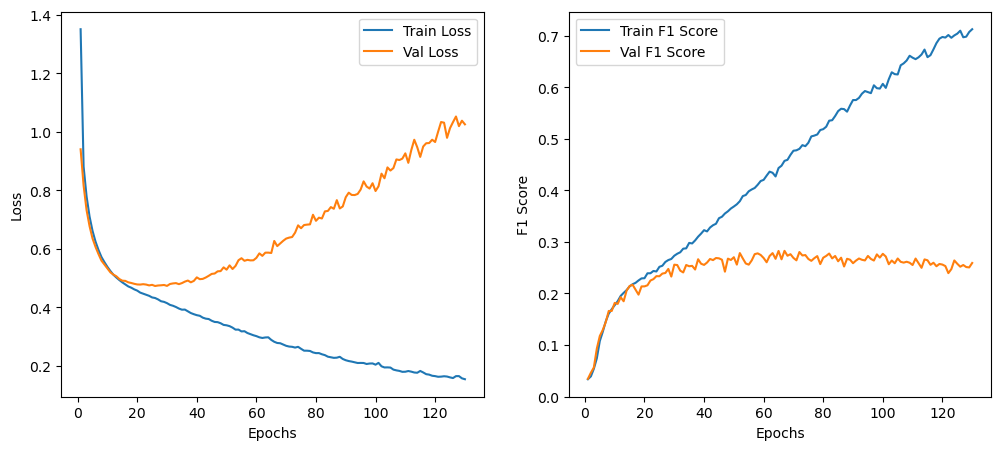

In [14]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, num_epochs + 1), val_f1_scores, label='Val F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.show()